In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 23 kB/s 
     |████████████████████████████████| 6.6 MB 27.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 8.2 MB/s 
  Created wheel fo

In [2]:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 7.4 MB/s 
     |████████████████████████████████| 50 kB 4.4 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220305-py3-none-any.whl size=61214 sha256=ae61a767a06a53888d5b74fc49ce22fd5ba342e3c5d8adadf712b4087985493c
  Stored in directory: /root/.cache/pip/wheels/b5/b7/6e/43b1693d06fac3633af48db68557513b0a37ab38b0a8b798f9
Successfully built fvcore


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transform CSV to COCO json

In [5]:

TRAIN_IMAGE_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_train.csv'
VALID_IMAGE_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_val.csv'
TEST_IMAGE_PATH  = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'
#IMAGES_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110K_fixed/images/'

In [6]:
import pandas as pd
from PIL import Image
import cv2
import numpy as np
import json


In [7]:

def pre_process_data(path,images_path =""):
  colnames=['filename','xmin', 'ymin', 'xmax', 'ymax',\
            'class','width','height']
  
  annotate_data=pd.read_csv(path,header=None)
  annotate_data.columns = colnames
  annotate_data['filename'] = images_path+annotate_data['filename'].astype(str)
  annotate_data = annotate_data[['filename', 'class','width', 'height', 'xmin','ymin','xmax','ymax']]
  return annotate_data

train_df = pre_process_data(TRAIN_IMAGE_PATH,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/train/images/')
valid_df = pre_process_data(VALID_IMAGE_PATH,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/valid/images/')
#test_df = pre_process_data(TEST_IMAGE_PATH,'/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images/')
test_df = pre_process_data('/content/drive/MyDrive/Tesis/testImages/anns_test.csv','/content/drive/MyDrive/Tesis/testImages/images/')

#test_df = pre_process_data('/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv','/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/')

In [8]:
def remove_images(df,N):
  """
  N is the number of images that you want to stay in the df
  """
  #images = random.sample(list(df['filename'].unique()),N)#images that stay in the df
  images = list(df['filename'].unique())#[:N]
  images.sort()
  images = images[:N]
  df = df[df['filename'].isin(images)]
  df.reset_index(inplace=True, drop=True)
  return df

train_df = remove_images(train_df,2876)
#valid_df = remove_images(valid_df,588)
#test_df = remove_images(test_df,1027)


In [9]:
print("Number of different images in train dataset: {0}".format(len(train_df['filename'].unique())))
train_df.head()

Number of different images in train dataset: 2876


,filename,class,width,height,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,35,91,71,138
1,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,215,326,231,374
2,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,192,351,214,367
3,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,177,353,190,382
4,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,165,345,176,369


In [ ]:
print("Number of different images in valid dataset: {0}".format(len(valid_df['filename'].unique())))
valid_df.head()

Number of different images in valid dataset: 588


,filename,class,width,height,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,1,176,48,198
1,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,102,131,129,164
2,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,132,134,162,164
3,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,166,134,196,168
4,/content/drive/MyDrive/Tesis/Datasets/SKU110k_...,object,512,512,197,135,228,169


In [ ]:
print("Number of different images in test dataset: {0}".format(len(test_df['filename'].unique())))
test_df.head()

Number of different images in test dataset: 271


,filename,class,width,height,xmin,ymin,xmax,ymax
0,/content/drive/MyDrive/Tesis/Datasets/Holosele...,object,1960,4032,50,442,436,974
1,/content/drive/MyDrive/Tesis/Datasets/Holosele...,object,1960,4032,479,425,705,960
2,/content/drive/MyDrive/Tesis/Datasets/Holosele...,object,1960,4032,710,405,888,954
3,/content/drive/MyDrive/Tesis/Datasets/Holosele...,object,1960,4032,1602,557,1776,914
4,/content/drive/MyDrive/Tesis/Datasets/Holosele...,object,1960,4032,113,1188,305,1594


In [10]:
#Paths where to save the generated dataframes
TRAIN_CSV = "/content/train_data.csv"
VALID_CSV = "/content/valid_data.csv"
TEST_CSV  = "/content/test_data.csv"

# #Save the dataframes to memory
train_df.to_csv(TRAIN_CSV, index=False)
valid_df.to_csv(VALID_CSV, index=False)
test_df.to_csv(TEST_CSV, index=False)

In [11]:

def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid
    category["name"] = row[2]
    return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = []
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin ]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation


def csv_to_coco(data,save_json_path):

    images = []
    categories = []
    annotations = []

    # _category = {}
    # _category["supercategory"] = 'none'
    # _category["id"] = 0
    # _category["name"] = 'None'
    # categories.append(_category)

    data['fileid'] = data['filename'].astype('category').cat.codes
    data['categoryid']= pd.Categorical(data['class'],ordered= True).codes
    data['categoryid'] = data['categoryid']+1
    data['annid'] = data.index

    for row in data.itertuples():
        annotations.append(annotation(row))

    imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
    for row in imagedf.itertuples():
        images.append(image(row))

    catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
    for row in catdf.itertuples():
        categories.append(category(row))

    data_coco = {}
    data_coco["images"] = images
    data_coco["categories"] = categories
    data_coco["annotations"] = annotations


    json.dump(data_coco, open(save_json_path, "w"), indent=4)

TRAIN_JSON_PATH = '/content/train_coco.json'
VALID_JSON_PATH = '/content/valid_coco.json'
TEST_JSON_PATH = '/content/test_coco.json'

csv_to_coco(train_df,TRAIN_JSON_PATH)
csv_to_coco(valid_df,VALID_JSON_PATH)
csv_to_coco(test_df,TEST_JSON_PATH)

#TRAIN_JSON_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/train.json'
#VALID_JSON_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/valid.json'
#TEST_JSON_PATH = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/test.json'





# Detectron2

In [12]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, TRAIN_JSON_PATH, "/content/train")
register_coco_instances("my_dataset_val", {}, VALID_JSON_PATH, "/content/valid")
register_coco_instances("my_dataset_test", {},TEST_JSON_PATH , "/content/test")


[09/02 01:05:02 d2.data.datasets.coco]: Loading /content/train_coco.json takes 2.36 seconds.
[09/02 01:05:02 d2.data.datasets.coco]: Loaded 2876 images in COCO format from /content/train_coco.json


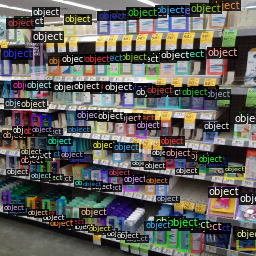

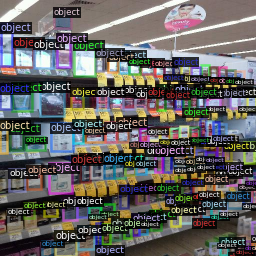

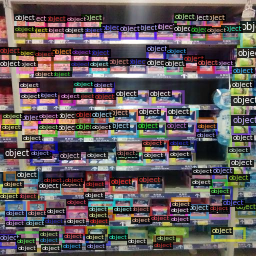

In [ ]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [20]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [21]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines
%%time
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 4000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: ignored

In [ ]:
%%time
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

[07/21 23:01:25 d2.data.datasets.coco]: Loading /content/test_coco.json takes 1.09 seconds.
[07/21 23:01:26 d2.data.datasets.coco]: Loaded 1027 images in COCO format from /content/test_coco.json
[07/21 23:01:27 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   object   | 149610       |
|            |              |
[07/21 23:01:27 d2.data.common]: Serializing 1027 elements to byte tensors and concatenating them all ...
[07/21 23:01:27 d2.data.common]: Serialized dataset takes 4.66 MiB
[07/21 23:01:27 d2.evaluation.evaluator]: Start inference on 1027 images
[07/21 23:01:41 d2.evaluation.evaluator]: Inference done 11/1027. 0.0704 s / img. ETA=0:01:37
[07/21 23:01:46 d2.evaluation.evaluator]: Inference done 54/1027. 0.0691 s / img. ETA=0:01:50
[07/21 23:01:51 d2.evaluation.evaluator]: Inference done 98/1027. 0.0692 s / img. ETA=0:01:45
[07/21 23:01:56 d2.evaluation.evaluator]: Inference done 143/1027. 0.0691 s

# Test images

In [ ]:
#load weights
from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 4000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


In [ ]:
%cp /content/drive/MyDrive/Tesis/objectDetectionWeights/Detectron2/model_final.pth /content/output/model_final.pth

In [ ]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

#with saved weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6   # set the testing threshold for this model #0.7
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")


In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/drive/MyDrive/Tesis/testImages/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  #print(outputs['instances'].scores.tolist())
  # print(outputs['instances'])
  # for bbox in outputs['instances'].pred_boxes:
  #   print(bbox.tolist())
  
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
   
                 )
  #print(outputs)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img = cv2.resize(out.get_image()[:, :, ::-1],(1024,1024))
  #cv2_imshow(img)

[0.9672372937202454, 0.9577627182006836, 0.9577019214630127, 0.9575275778770447, 0.9544589519500732, 0.9532840847969055, 0.951367974281311, 0.9492068290710449, 0.9414436221122742, 0.9363408088684082, 0.9325675368309021, 0.9312183856964111, 0.9283920526504517, 0.9256350994110107, 0.9252812266349792, 0.9229312539100647, 0.9108878970146179, 0.910685658454895, 0.9076405167579651, 0.906991183757782, 0.8984761238098145, 0.8961520791053772, 0.8951505422592163, 0.8917300701141357, 0.8898587822914124, 0.876876950263977, 0.8747957348823547, 0.8654822707176208, 0.8651869893074036, 0.8616016507148743, 0.8586292862892151, 0.8535243272781372, 0.847518801689148, 0.8395681381225586, 0.8374359607696533, 0.821561336517334, 0.8097056746482849, 0.8075012564659119, 0.8073448538780212, 0.7984444499015808, 0.7950370907783508, 0.7857025861740112, 0.777986466884613, 0.7662904858589172, 0.7632434964179993, 0.7632377743721008, 0.7612828016281128, 0.73154217004776, 0.7052306532859802, 0.7030803561210632, 0.702703

In [ ]:
def read_images_IQA(filename):
  f,ans = open(filename,"r"),list()
  for line in f:
    ans.append(line.strip().split()[1])
  f.close()
  return ans

In [ ]:

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from itertools import product
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#https://towardsdatascience.com/evaluating-performance-of-an-object-detection-model-137a349c517b
INF = float('inf')



def get_images_and_boxes(filename):
    ans = {}
    f = open(filename,"r")
    for line in f:
        line = line.strip().split(",")
        if(ans.get(line[0]) == None):
            ans[line[0]] = [[int(line[i]) for i in range(1,5)]]
        else:
            ans[line[0]].append([int(line[i]) for i in range(1,5)])
    f.close()
    return ans



def drawBox(boxes, image):
    for i in range (0, len(boxes)):
        cv2.rectangle(image,(boxes[i][0],boxes[i][1]),(boxes[i][2],boxes[i][3]),(255, 0, 0),1)
    b,g,r = cv2.split(image)           # get b, g, r
    image = cv2.merge([r,g,b])     # switch it to r, g, b
        
    #cv2.namedWindow('final', cv2.WINDOW_NORMAL)
    cv2_imshow(image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        return 0
        #raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        #print("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        return 0
        #raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)


def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

def  get_avg_precision_at_iou(gt_boxes, pred_bb, iou_thr=0.5):
    
    model_scores = get_model_scores(pred_bb)
    sorted_model_scores= sorted(model_scores.keys())# Sort the predicted boxes in descending order (lowest scoring boxes first):
    for img_id in pred_bb.keys():
        
        arg_sort = np.argsort(pred_bb[img_id]['scores'])
        pred_bb[img_id]['scores'] = np.array(pred_bb[img_id]['scores'])[arg_sort].tolist()
        pred_bb[img_id]['boxes'] = np.array(pred_bb[img_id]['boxes'])[arg_sort].tolist()
    pred_boxes_pruned = deepcopy(pred_bb)
        
    
    precisions = []
    recalls = []
    model_thrs = []
    img_results = {}# Loop over model score thresholds and calculate precision, recall
    for ithr, model_score_thr in enumerate(sorted_model_scores[:-1]):
            # On first iteration, define img_results for the first time:
        #print("Model score : ", model_score_thr)
        img_ids = gt_boxes.keys() if ithr == 0 else model_scores[model_score_thr]
        for img_id in img_ids:
            #print("Image {0} processed".format(img_id))
            gt_boxes_img = gt_boxes[img_id]
            box_scores = pred_boxes_pruned[img_id]['scores']
            start_idx = 0
            for score in box_scores:
                if score <= model_score_thr:
                    pred_boxes_pruned[img_id]
                    start_idx += 1
                else:
                    break 
            # Remove boxes, scores of lower than threshold scores:
            pred_boxes_pruned[img_id]['scores']= pred_boxes_pruned[img_id]['scores'][start_idx:]
            pred_boxes_pruned[img_id]['boxes']= pred_boxes_pruned[img_id]['boxes'][start_idx:]# Recalculate image results for this image
            #print(img_id)
            img_results[img_id] = get_single_image_results(gt_boxes_img, pred_boxes_pruned[img_id]['boxes'], iou_thr)# calculate precision and recall
        prec, rec = calc_precision_recall(img_results)
        precisions.append(prec)
        recalls.append(rec)
        model_thrs.append(model_score_thr)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    prec_at_rec = []
    print("Processing recall...")
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args= np.argwhere(recalls>recall_level).flatten()
            prec= max(precisions[args])
            #print(recalls,"Recall")
            #print(      recall_level,"Recall Level")
            #print(       args, "Args")
            #print(       prec, "precision")
        except ValueError:
            prec=0.0
        prec_at_rec.append(prec)
    avg_prec = np.mean(prec_at_rec) 
    return {
        'avg_prec': avg_prec,
        'precisions': precisions,
        'recalls': recalls,
        'model_thrs': model_thrs}


def compare(path_images,filename,selected_images = None):
    i = 0
    gt_boxes = {}
    pred_boxes = {}
    images_and_boxes = get_images_and_boxes(filename)
    test_images_names = list(test_df['filename'])
    if(selected_images != None):
      test_images_names = [f for f in test_images_names if f.replace(path_images,'') in selected_images]
      print(test_images_names)
    image_results = {}
    while i < len(test_images_names):
        
        name = test_images_names[i].replace(path_images,'')
        
        
        image = cv2.imread(test_images_names[i],3)#,cv2.COLOR_BGR2RGB)
        
        b,g,r = cv2.split(image)           # get b, g, r
        image = cv2.merge([r,g,b])     # switch it to r, g, b
        
        real_boxes = images_and_boxes[name]
        
       
        gt_boxes[name] = [list(bbox) for bbox in real_boxes]
       
        outputs = predictor(image)
        
        pred_boxes[name] = {"boxes":[list([num for num in bbox.tolist()]) for bbox in outputs['instances'].pred_boxes],"scores":list(outputs['instances'].scores.tolist())}
        # print(pred_boxes[name]['boxes'])
        # image = cv2.imread(test_images_names[i],3)#,cv2.COLOR_BGR2RGB)
        # b,g,r = cv2.split(image)           # get b, g, r
        # image = cv2.merge([r,g,b])     # switch it to r, g, b
        # drawBox(pred_boxes[name]['boxes'],image)

        # image = cv2.imread(test_images_names[i],3)#,cv2.COLOR_BGR2RGB)
        # b,g,r = cv2.split(image)           # get b, g, r
        # image = cv2.merge([r,g,b])     # switch it to r, g, b
        # drawBox(gt_boxes[name],image)
        #if(i == 4):break
        i += 1
    print("Begining...")
    
    for k in gt_boxes.keys():
      image_results[k] = get_single_image_results(gt_boxes[k],pred_boxes[k]['boxes'],0.6)
    print(calc_precision_recall(image_results))
    
    res = get_avg_precision_at_iou(gt_boxes,pred_boxes,0.6)
    print("\nP: {}".format(np.mean(res['precisions'])))
    print("R: {}".format(np.mean(res['recalls'])))
    print("Ap: {}".format(res['avg_prec']))

In [ ]:

path_results = '/content/yolov5/runs/val/exp/labels'

path_original = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/labels'

path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images/'

filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'

compare(path_images,filename)

Begining...
Processing recall...

P: 0.9658988246563192
R: 0.30998182155461823
Ap: 0.5315778247592228


In [ ]:

path_images = '/content/drive/MyDrive/Tesis/testImages/images/'

filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'

compare(path_images,filename)

Begining...
(0.648493543758967, 0.5689112649465072)
Processing recall...

P: 0.7861619600701815
R: 0.33479840014691964
Ap: 0.45734925731384163


In [ ]:

path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/'

filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'

compare(path_images,filename)

Begining...
(0.745547390708681, 0.6515728747142702)
Processing recall...

P: 0.7989335105392054
R: 0.36555464486653305
Ap: 0.5300359686532612


In [ ]:
#best images sku110k
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/SKU110k_best_images.txt")

path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images/'

filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'

compare(path_images,filename,selected_images)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#worst images sku110k
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/SKU110k_worst_images.txt")

path_images = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/test/images/'

filename = '/content/drive/MyDrive/Tesis/Datasets/SKU110k_512x512_reduced/annotations/annotations_test.csv'

compare(path_images,filename,selected_images)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#best images productos
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/productos_best_images.txt")

path_images = '/content/drive/MyDrive/Tesis/testImages/images/'

filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'

compare(path_images,filename,selected_images)


['/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1260.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_12

In [ ]:
#worst images productos
selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/productos_worst_images.txt")

path_images = '/content/drive/MyDrive/Tesis/testImages/images/'

filename = '/content/drive/MyDrive/Tesis/testImages/anns_test.csv'

compare(path_images,filename,selected_images)

['/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_1266.jpg', '/content/drive/MyDrive/Tesis/testImages/images/IMG_12

In [ ]:
#best images holoselecta

selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/holoselecta_best_images.txt")

path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/'

filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'

compare(path_images,filename,selected_images)

['/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_125954.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/IMG_20181218_1259

In [ ]:
#worst images holoselecta

selected_images = read_images_IQA("/content/drive/MyDrive/Tesis/resultsIQA/holoselecta_worst_images.txt")

path_images = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/'

filename = '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/annotations/annotations.csv'

compare(path_images,filename,selected_images)

['/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDrive/Tesis/Datasets/Holoselecta/images/20190111_111600_HoloLens.jpg', '/content/drive/MyDr

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob
import time

for imageName in glob.glob('/content/drive/MyDrive/Tesis/testImages/images/*jpg'):
  im = cv2.imread(imageName)
  start_time = time.time()
  outputs = predictor(im)
  print("--- %s seconds ---" % (time.time() - start_time))
  break
  #print(outputs['instances'].scores.tolist())
  # print(outputs['instances'])
  # for bbox in outputs['instances'].pred_boxes:
  #   print(bbox.tolist())
  
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
   
                 )
  #print(outputs)
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  img = cv2.resize(out.get_image()[:, :, ::-1],(1024,1024))
  #cv2_imshow(img)

--- 0.2770359516143799 seconds ---
